In [29]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import random
import glob
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress Bar 출력

In [30]:
# image 데이터셋 root 폴더
root = 'BIRDS' 

folders = glob.glob(os.path.join(root, '*'))
print(folders)

['BIRDS\\ABBOTTS BABBLER', 'BIRDS\\ABBOTTS BOOBY', 'BIRDS\\ABYSSINIAN GROUND HORNBILL', 'BIRDS\\AFRICAN CROWNED CRANE', 'BIRDS\\AFRICAN EMERALD CUCKOO', 'BIRDS\\AFRICAN FIREFINCH', 'BIRDS\\AFRICAN OYSTER CATCHER', 'BIRDS\\AFRICAN PIED HORNBILL', 'BIRDS\\AFRICAN PYGMY GOOSE', 'BIRDS\\ALBATROSS', 'BIRDS\\ALBERTS TOWHEE', 'BIRDS\\ALEXANDRINE PARAKEET', 'BIRDS\\ALPINE CHOUGH', 'BIRDS\\ALTAMIRA YELLOWTHROAT', 'BIRDS\\AMERICAN AVOCET', 'BIRDS\\AMERICAN BITTERN', 'BIRDS\\AMERICAN COOT', 'BIRDS\\AMERICAN DIPPER', 'BIRDS\\AMERICAN FLAMINGO', 'BIRDS\\AMERICAN GOLDFINCH', 'BIRDS\\AMERICAN KESTREL', 'BIRDS\\AMERICAN PIPIT', 'BIRDS\\AMERICAN REDSTART', 'BIRDS\\AMERICAN ROBIN', 'BIRDS\\AMERICAN WIGEON', 'BIRDS\\AMETHYST WOODSTAR', 'BIRDS\\ANDEAN GOOSE', 'BIRDS\\ANDEAN LAPWING', 'BIRDS\\ANDEAN SISKIN', 'BIRDS\\ANHINGA', 'BIRDS\\ANIANIAU', 'BIRDS\\ANNAS HUMMINGBIRD', 'BIRDS\\ANTBIRD', 'BIRDS\\ANTILLEAN EUPHONIA', 'BIRDS\\APAPANE', 'BIRDS\\APOSTLEBIRD', 'BIRDS\\ARARIPE MANAKIN', 'BIRDS\\ASHY STORM PETR

In [31]:
# train: test ratio. 0.2로 설정시 test set의 비율은 20%로 설정
test_size = 0.2

# train / test 셋의 파일을 나눕니다.
train_images = []
test_images = []

for folder in folders:
    label = os.path.basename(folder)
    files = sorted(glob.glob(folder + '/*'))

    # 각 Label별 이미지 데이터셋 셔플
    random.seed(42)
    random.shuffle(files)

    idx = int(len(files) * test_size)
    train = files[:-idx]
    test = files[-idx:]

    train_images.extend(train)
    test_images.extend(test)

# train, test 전체 이미지 셔플
random.shuffle(train_images)
random.shuffle(test_images)

# Class to Index 생성. {'ABBOTTS BABBLER': 0, 'AMERICAN WIGEON': 1}
class_to_idx = {os.path.basename(f):idx for idx, f in enumerate(folders)}
classCount = len(class_to_idx)
print("Classes:" , classCount)
print("AVG_train: " + str(len(train_images)/classCount))
print("AVG_test: " + str(len(test_images)/classCount))

# Label 생성
train_labels = [f.split('\\')[-2] for f in train_images]
test_labels = [f.split('\\')[-2] for f in test_images]

Classes: 525
AVG_train: 133.2095238095238
AVG_test: 32.819047619047616


In [32]:
print('==='*10)
print(f'train images: {len(train_images)}')
print(f'train labels: {len(train_labels)}')
print(f'test images: {len(test_images)}')
print(f'test labels: {len(test_labels)}')

train images: 69935
train labels: 69935
test images: 17230
test labels: 17230


In [33]:
# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, files, labels, Label_to_idx, transform):
        super(CustomImageDataset, self).__init__()
        self.files = files
        self.labels = labels
        self.Label_to_idx = Label_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # file 경로
        file = self.files[idx]
        # PIL.Image로 이미지 로드
        img = Image.open(file).convert('RGB')
        # transform 적용
        img = self.transform(img)
        # label 생성
        lbl = self.Label_to_idx[self.labels[idx]]
        # image, label return
        return img, lbl

In [34]:
train_transform = transforms.Compose([
    transforms.Resize((227, 227)),          # 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.ToTensor(), 
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((227, 227)),      # 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.ToTensor(), 
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # 이미지 정규화
])

In [35]:
# train, test 데이터셋 생성
train_dataset = CustomImageDataset(train_images, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_images, test_labels, class_to_idx, test_transform)

In [36]:
# train, test 데이터 로더 생성 => 모델 학습시 입력하는 데이터셋
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True
                         )

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False #test는 굳이 할 필요 없습니다.
                        )

In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [38]:
# AlexNet 구현
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.feature_extractor = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
                                                nn.ReLU(),
                                                nn.MaxPool2d(kernel_size=3, stride=2),
                                                nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), 
                                                nn.ReLU(),
                                                nn.MaxPool2d(kernel_size=3, stride=2),
                                                nn.Conv2d(256, 384, 3, padding=1),
                                                nn.ReLU(),
                                                nn.Conv2d(384, 384, 3, padding=1),
                                                nn.ReLU(),
                                                nn.Conv2d(384, 256, 3, padding=1),
                                                nn.ReLU(),
                                                nn.MaxPool2d(3, 2),
                                                # 추가 레이어
                                                nn.Conv2d(256, 128, 1),
                                                nn.ReLU(),
                                                nn.Conv2d(128, 512, 3, padding=1),
                                                nn.ReLU(),
                                                nn.Conv2d(512, 512, 3, padding=1),
                                                nn.ReLU(),
                                                nn.Conv2d(512, 256, 3, padding=1),
                                                nn.ReLU(),
                                                nn.MaxPool2d(2, 1)
                                                )
        self.classifier = nn.Sequential(nn.Dropout(p=0.5),
                                        nn.Linear(in_features=256 * 5 * 5, out_features=4096),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Linear(4096, classCount))
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 256 * 5 * 5)
        x = self.classifier(x)
        return x
  
# 모델의 구조도 출력  
model = AlexNet().to(device)
print(model)

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (14): ReLU()
    (15): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [40]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        prograss_bar.set_description("Loss %.04f" % (loss.item()))
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [41]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [42]:
# 최대 Epoch을 지정합니다.
num_epochs = 20
model_name = 'AlexNet'
train_loss_ = []
val_loss_ = []
savePoint = []

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device)
    train_loss_.append(train_loss)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, criterion, device)
    val_loss_.append(val_loss)
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model, f'{model_name}.pt')
        savePoint = [epoch, val_loss]
        
    print("---------"*10)

Loss 5.8645: 100%|██████████| 2186/2186 [02:35<00:00, 14.05it/s]


epoch 01, loss: 6.21496, acc: 0.00340, val_loss: 5.93737, val_accuracy: 0.00644
[INFO] val_loss has been improved from inf to 5.93737. Saving Model!
------------------------------------------------------------------------------------------


Loss 4.8097: 100%|██████████| 2186/2186 [02:31<00:00, 14.39it/s]


epoch 02, loss: 5.40862, acc: 0.02479, val_loss: 4.84103, val_accuracy: 0.06164
[INFO] val_loss has been improved from 5.93737 to 4.84103. Saving Model!
------------------------------------------------------------------------------------------


Loss 3.8687: 100%|██████████| 2186/2186 [02:29<00:00, 14.60it/s]


epoch 03, loss: 4.37785, acc: 0.10843, val_loss: 3.84825, val_accuracy: 0.17725
[INFO] val_loss has been improved from 4.84103 to 3.84825. Saving Model!
------------------------------------------------------------------------------------------


Loss 3.7530: 100%|██████████| 2186/2186 [02:29<00:00, 14.60it/s]


epoch 04, loss: 3.48700, acc: 0.23267, val_loss: 3.09714, val_accuracy: 0.31358
[INFO] val_loss has been improved from 3.84825 to 3.09714. Saving Model!
------------------------------------------------------------------------------------------


Loss 2.2333: 100%|██████████| 2186/2186 [02:28<00:00, 14.69it/s]


epoch 05, loss: 2.84904, acc: 0.34502, val_loss: 2.64755, val_accuracy: 0.40435
[INFO] val_loss has been improved from 3.09714 to 2.64755. Saving Model!
------------------------------------------------------------------------------------------


Loss 2.3229: 100%|██████████| 2186/2186 [02:31<00:00, 14.40it/s]


epoch 06, loss: 2.36460, acc: 0.43871, val_loss: 2.37707, val_accuracy: 0.45293
[INFO] val_loss has been improved from 2.64755 to 2.37707. Saving Model!
------------------------------------------------------------------------------------------


Loss 2.6918: 100%|██████████| 2186/2186 [02:33<00:00, 14.25it/s]


epoch 07, loss: 1.99403, acc: 0.51150, val_loss: 2.12977, val_accuracy: 0.50720
[INFO] val_loss has been improved from 2.37707 to 2.12977. Saving Model!
------------------------------------------------------------------------------------------


Loss 1.8552: 100%|██████████| 2186/2186 [02:37<00:00, 13.91it/s]


epoch 08, loss: 1.69228, acc: 0.57133, val_loss: 1.96527, val_accuracy: 0.54034
[INFO] val_loss has been improved from 2.12977 to 1.96527. Saving Model!
------------------------------------------------------------------------------------------


Loss 0.5688: 100%|██████████| 2186/2186 [02:36<00:00, 13.96it/s]


epoch 09, loss: 1.45024, acc: 0.62621, val_loss: 1.83901, val_accuracy: 0.57179
[INFO] val_loss has been improved from 1.96527 to 1.83901. Saving Model!
------------------------------------------------------------------------------------------


Loss 1.3568: 100%|██████████| 2186/2186 [02:35<00:00, 14.09it/s]


epoch 10, loss: 1.24178, acc: 0.66934, val_loss: 1.82650, val_accuracy: 0.58456
[INFO] val_loss has been improved from 1.83901 to 1.82650. Saving Model!
------------------------------------------------------------------------------------------


Loss 0.8328: 100%|██████████| 2186/2186 [02:35<00:00, 14.04it/s]


epoch 11, loss: 1.06775, acc: 0.70850, val_loss: 1.80852, val_accuracy: 0.60087
[INFO] val_loss has been improved from 1.82650 to 1.80852. Saving Model!
------------------------------------------------------------------------------------------


Loss 1.4221: 100%|██████████| 2186/2186 [02:43<00:00, 13.37it/s]


epoch 12, loss: 0.91499, acc: 0.74536, val_loss: 1.77289, val_accuracy: 0.61840
[INFO] val_loss has been improved from 1.80852 to 1.77289. Saving Model!
------------------------------------------------------------------------------------------


Loss 0.7977: 100%|██████████| 2186/2186 [02:40<00:00, 13.60it/s]


epoch 13, loss: 0.78325, acc: 0.77601, val_loss: 1.82495, val_accuracy: 0.61277
------------------------------------------------------------------------------------------


Loss 0.6828: 100%|██████████| 2186/2186 [02:36<00:00, 13.93it/s]


epoch 14, loss: 0.67489, acc: 0.80416, val_loss: 1.85893, val_accuracy: 0.63494
------------------------------------------------------------------------------------------


Loss 0.6197: 100%|██████████| 2186/2186 [02:38<00:00, 13.78it/s]


epoch 15, loss: 0.58252, acc: 0.82753, val_loss: 1.91231, val_accuracy: 0.62966
------------------------------------------------------------------------------------------


Loss 0.4301: 100%|██████████| 2186/2186 [02:36<00:00, 13.92it/s]


epoch 16, loss: 0.50487, acc: 0.84616, val_loss: 1.94701, val_accuracy: 0.63430
------------------------------------------------------------------------------------------


Loss 0.1274: 100%|██████████| 2186/2186 [02:38<00:00, 13.81it/s]


epoch 17, loss: 0.44657, acc: 0.86256, val_loss: 1.95597, val_accuracy: 0.63430
------------------------------------------------------------------------------------------


Loss 0.6081: 100%|██████████| 2186/2186 [02:37<00:00, 13.88it/s]


epoch 18, loss: 0.40062, acc: 0.87600, val_loss: 1.97069, val_accuracy: 0.63575
------------------------------------------------------------------------------------------


Loss 0.7152: 100%|██████████| 2186/2186 [02:39<00:00, 13.67it/s]


epoch 19, loss: 0.35604, acc: 0.88907, val_loss: 2.07755, val_accuracy: 0.64301
------------------------------------------------------------------------------------------


Loss 0.2315: 100%|██████████| 2186/2186 [02:38<00:00, 13.75it/s]


epoch 20, loss: 0.32869, acc: 0.89685, val_loss: 2.19568, val_accuracy: 0.64393
------------------------------------------------------------------------------------------


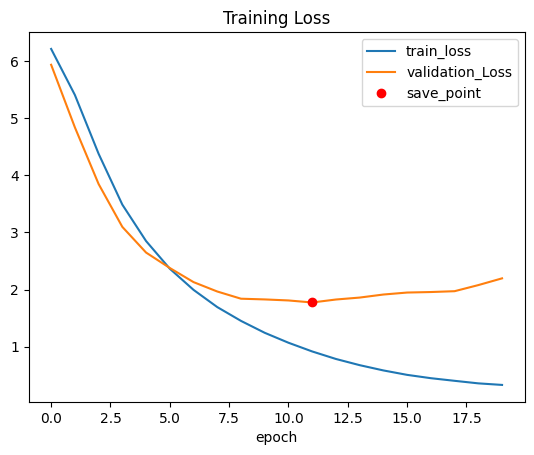

In [43]:
import matplotlib.pyplot as plt

plt.plot(train_loss_, label='train_loss')
plt.plot(val_loss_, label='validation_Loss')
plt.plot(savePoint[0], savePoint[1], 'ro', label='save_point')
plt.title("Training Loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [44]:
alexNet = torch.load("AlexNet.pt", map_location=device)

In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
# Test 데이터 셋 중 맞은 확률     
print('Accuracy of the network on the 2,758 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 2,758 test images: 61 %


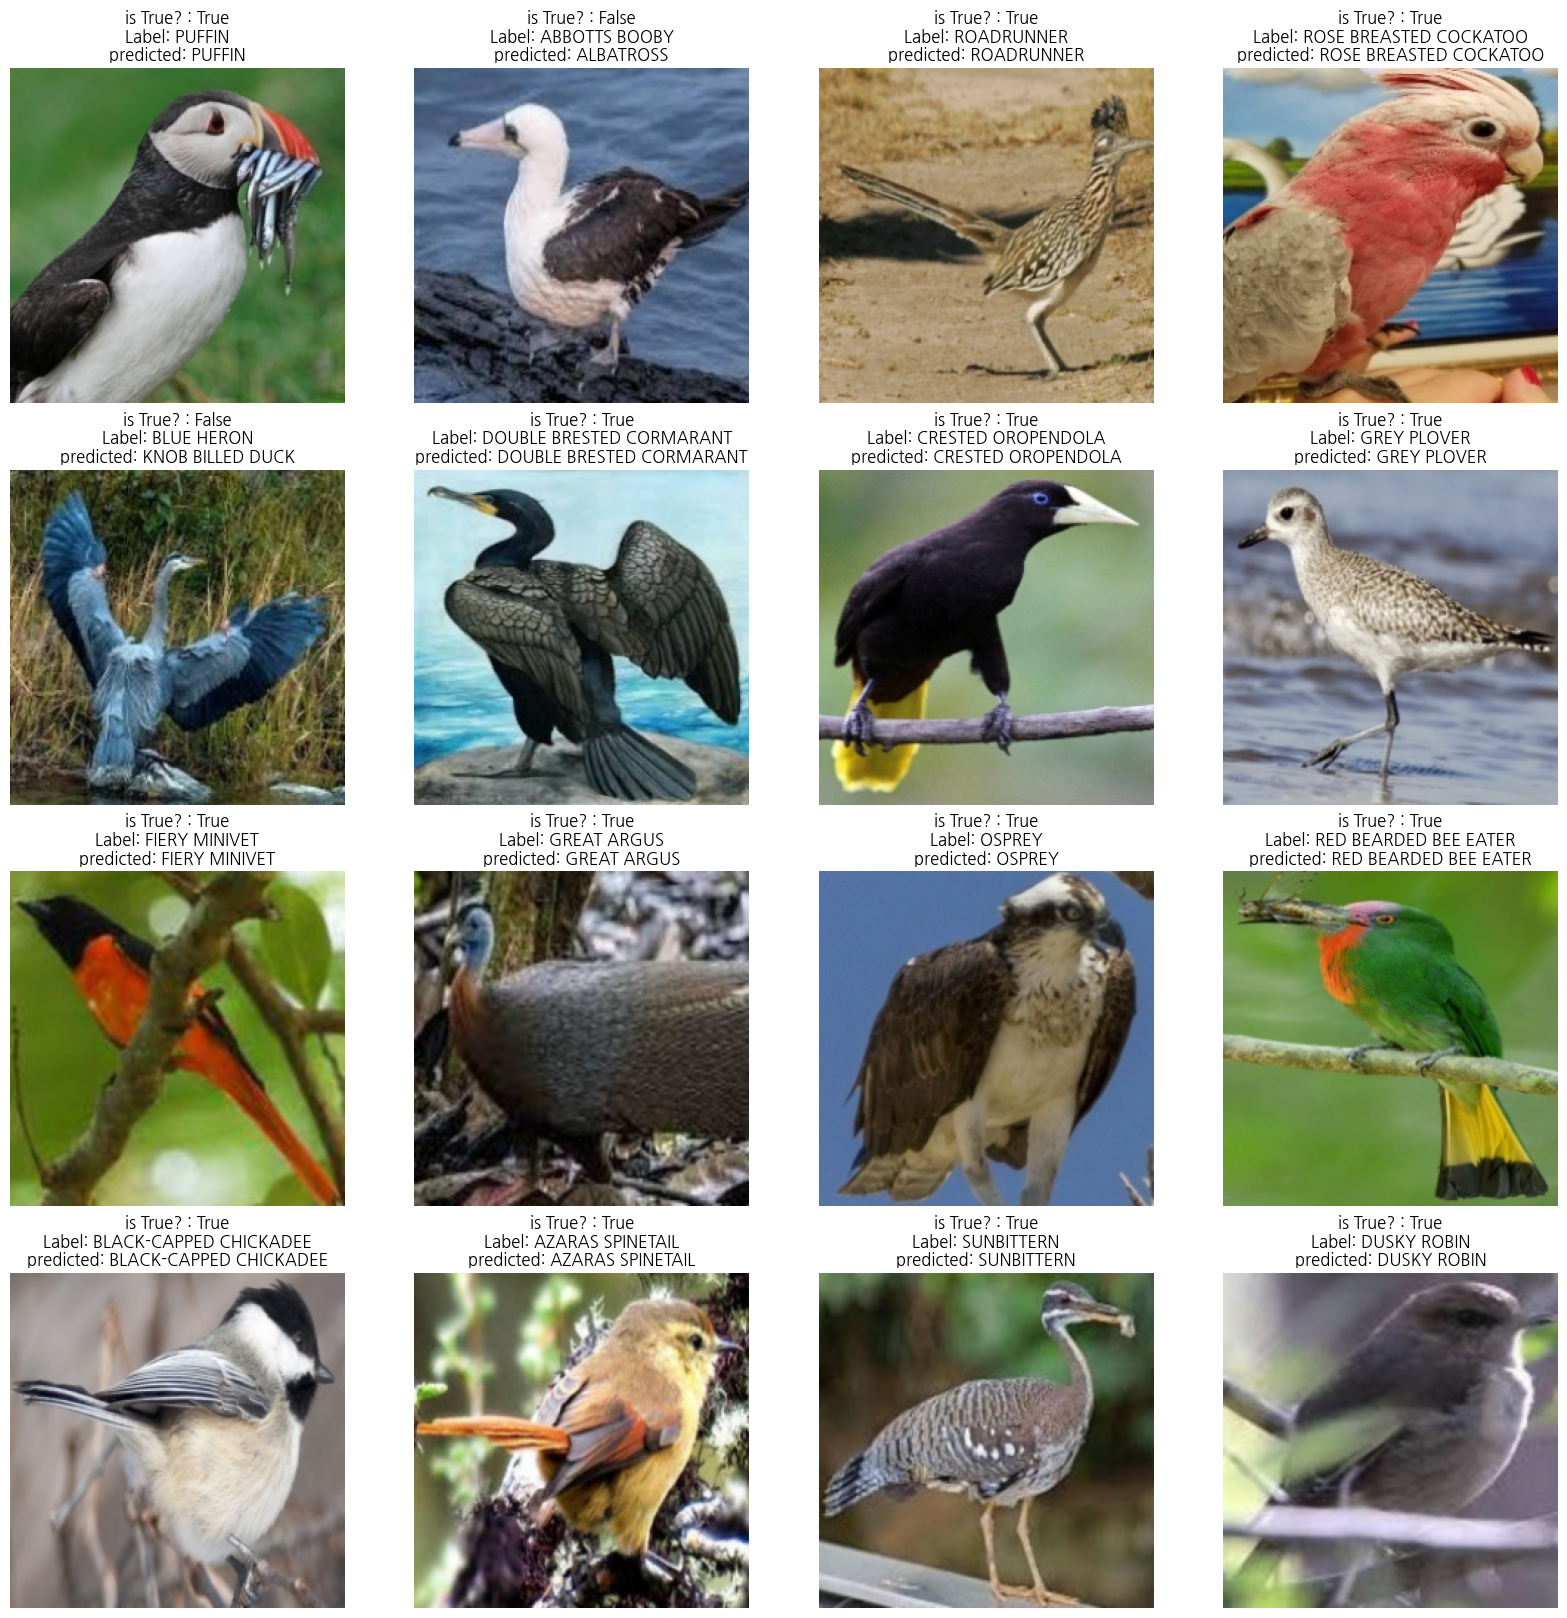

In [50]:
with torch.no_grad():
    data = next(iter(train_loader))
    images, labels = data[0].to(device), data[1].to(device)
    outputs = alexNet(images)
    _, predicted = torch.max(outputs.data, 1)
    
labels_map = {v:k for k, v in train_dataset.Label_to_idx.items()}
plt.rcParams['font.family'] = 'NanumGothic'
figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label, predict = images[i].cpu(), labels[i].cpu().item(), predicted[i].cpu().item()
    
    plt.title("is True? : " + str(labels_map[label] == labels_map[predict]) + "\nLabel: "+ labels_map[label] + "\npredicted: " + labels_map[predict])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    # plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.imshow(transforms.ToPILImage()(img*0.5+0.5))
plt.show()